In [32]:
import torch
from vq_vae_model import VQVAE

import clip
import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
from torchvision import transforms
from torch import nn, optim
from tqdm import tqdm

import open_clip

from torch.cuda.amp import GradScaler, autocast

import random

from torch.nn.functional import pad

import time

In [2]:
torch.cuda.empty_cache()

## Load CLIP Model

In [3]:
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:10809'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:10809'

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-H-14',
    pretrained='laion2b_s32b_b79k',
    cache_dir="D:\\jupyter_work_cache\\huggingface\\hub\\models--laion--CLIP-ViT-H-14-laion2B-s32B-b79K",  
    device="cuda"
)

clip_tokenizer = open_clip.get_tokenizer('ViT-H-14')

## Load Transformer Dataset

In [ ]:
class TransformerDataset(Dataset):
    def __init__(
        self,
        csv_path,
        image_dir,
        mel_dir,
        clip_model,
        clip_preprocess,
        max_time_steps=None,
        cache_dir="F:\\Jupyter\\transformer_dataset_cache3",
        preload_in_memory=False
    ):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.mel_dir = mel_dir
        self.clip_model = clip_model
        self.clip_preprocess = clip_preprocess
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.max_time_steps = max_time_steps or self._find_max_time_steps()
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

        
        self.preloaded = None
        if preload_in_memory:
            self.preloaded = []
            for idx in range(len(self.data)):
                cache_path = os.path.join(self.cache_dir, f"{idx}.pt")
                if not os.path.exists(cache_path):
                    self._generate_and_save(idx)

                try:
                    tup = torch.load(cache_path, map_location='cpu')
                except Exception as e:
                    print(f"[WARNING] Preload failed for {cache_path}, regenerating. Error: {e}")
                    self._generate_and_save(idx)
                    tup = torch.load(cache_path, map_location='cpu')

                self.preloaded.append(tup)

    # ---------- Retry-safe load/save ----------
    def _safe_load(self, path, map_location='cpu', max_retries=3, sleep_sec=1):
        for attempt in range(max_retries):
            try:
                return torch.load(path, map_location=map_location)
            except Exception as e:
                print(f"[WARNING] Load failed at {path}, attempt {attempt+1}/{max_retries}. Error: {e}")
                time.sleep(sleep_sec)
        raise RuntimeError(f"[ERROR] Failed to load {path} after {max_retries} retries.")

    def _find_max_time_steps(self):
        max_time = 0
        for fname in self.data['mel_file']:
            path = os.path.join(self.mel_dir, fname)
            if os.path.exists(path):
                m = np.load(path)
                if m.ndim == 2:
                    max_time = max(max_time, m.shape[1])
        return max_time

    def _generate_and_save(self, idx):
        
        row = self.data.iloc[idx]
        cache_path = os.path.join(self.cache_dir, f"{idx}.pt")

        text = (
            f'"{row["Art_Utterance"]}". '
            f'Painting Emotion: {row["painting_emotion"]}. '
            f'Audio: {row["audioset_label"]}. '
            f'Audio keywords: {row["audio_caption_keywords"]}.'
        )
        text_tokens = clip_tokenizer([text]).to("cuda")
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens).unsqueeze(0)

        # image encoding
        image_path = os.path.join(self.image_dir, row['image_file'])
        image = Image.open(image_path).convert("RGB")
        image_input = self.clip_preprocess(image).unsqueeze(0).to("cuda")
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_input).unsqueeze(0)
    
        # process Mel-spectrogram
        mel_path = os.path.join(self.mel_dir, row['mel_file'])
        mel_spectrogram = np.load(mel_path)
        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
    
        # padding or cut
        current_time_steps = mel_spectrogram.shape[1]
        if current_time_steps < self.max_time_steps:
            mel_spectrogram = F.pad(mel_spectrogram, (0, self.max_time_steps - current_time_steps), "constant", 0)
        elif current_time_steps > self.max_time_steps:
            mel_spectrogram = mel_spectrogram[:, :self.max_time_steps]
    
        mel_input = mel_spectrogram.unsqueeze(0).to("cuda")

        # save cache
        torch.save((image_features, text_features, mel_input), cache_path)

    def generate_all_cache(self):
        """Pre-generate the cache of all samples offline to the local folder"""
        for idx in range(len(self.data)):
            cache_path = os.path.join(self.cache_dir, f"{idx}.pt")
            if not os.path.exists(cache_path):
                self._generate_and_save(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        cache_path = os.path.join(self.cache_dir, f"{idx}.pt")
        # Give priority to using preloaded lists
        if self.preloaded is not None:
            img_feat, txt_feat, mel_input = self.preloaded[idx]
            return img_feat.to(self.device), txt_feat.to(self.device), mel_input.to(device)

        # Make sure the disk cache exists; otherwise, generate and save
        if not os.path.exists(cache_path):
            self._generate_and_save(idx)
        try:
            img_feat, txt_feat, mel_input = self._safe_load(cache_path, map_location=self.device)
        except Exception as e:
            print(f"[WARNING] Cache corrupted at {cache_path}, regenerating. Error: {e}")
            self._generate_and_save(idx)
            img_feat, txt_feat, mel_input = self._safe_load(cache_path, map_location=self.device)
            # 确保 image/text 特征为 [1024]
        img_feat = img_feat.view(-1).to(self.device)   # [1024]
        txt_feat = txt_feat.view(-1).to(self.device)   # [1024]

        return img_feat, txt_feat, mel_input


In [19]:
transformer_train_csv = "../../data/transformer_dataset/train/train.csv"
transformer_train_mel = "../../data/transformer_dataset/train/mel"
transformer_train_img = "../../data/transformer_dataset/train/images"

transformer_val_csv = "../../data/transformer_dataset/val/val.csv"
transformer_val_mel = "../../data/transformer_dataset/val/mel"
transformer_val_img = "../../data/transformer_dataset/val/images"

transformer_test_csv = "../../data/transformer_dataset/test/test.csv"
transformer_test_mel = "../../data/transformer_dataset/test/mel"
transformer_test_img = "../../data/transformer_dataset/test/images"

In [20]:
batch_size = 32
num_workers = 0

In [21]:
transformer_train_dataset = TransformerDataset(transformer_train_csv, transformer_train_img, transformer_train_mel, clip_model, clip_preprocess, cache_dir="F:\\Jupyter\\transformer_dataset_cache3\\train\\")
transformer_val_dataset = TransformerDataset(transformer_val_csv, transformer_val_img, transformer_val_mel, clip_model, clip_preprocess, cache_dir="F:\\Jupyter\\transformer_dataset_cache3\\val\\")
transformer_test_dataset = TransformerDataset(transformer_test_csv, transformer_test_img, transformer_test_mel, clip_model, clip_preprocess, cache_dir="F:\\Jupyter\\transformer_dataset_cache3\\test\\")

transformer_train_loader = DataLoader(transformer_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
transformer_val_loader = DataLoader(transformer_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
transformer_test_loader = DataLoader(transformer_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [22]:
image_feat, text_feat, mel_truth = transformer_train_loader.dataset[38]  
print("随机一个样本输出:")
print("image_feat shape:", image_feat.shape)
print("text_feat shape:", text_feat.shape)
print("mel_truth shape:", mel_truth.shape)

print("image_feat:", image_feat)
print("text_feat:", text_feat)
print("mel_truth:", mel_truth)

随机一个样本输出:
image_feat shape: torch.Size([1024])
text_feat shape: torch.Size([1024])
mel_truth shape: torch.Size([1, 80, 862])
image_feat: tensor([-0.4071, -0.7864, -0.2119,  ..., -0.1508, -0.2357,  0.5752],
       device='cuda:0')
text_feat: tensor([-0.4266,  0.7688, -0.4117,  ..., -0.7122,  0.1416,  0.2033],
       device='cuda:0')
mel_truth: tensor([[[ 0.8887,  0.8611,  0.7347,  ...,  0.9219,  0.9682,  0.9877],
         [ 0.6172,  0.6736,  0.6712,  ...,  0.8011,  0.8020,  0.9021],
         [ 0.6070,  0.5646,  0.6173,  ...,  0.6667,  0.6092,  0.5743],
         ...,
         [-0.6077, -0.5692, -0.5620,  ..., -0.6189, -0.6583, -0.6580],
         [-0.6764, -0.6657, -0.6119,  ..., -0.6896, -0.6849, -0.5871],
         [-0.8105, -0.8139, -0.7636,  ..., -0.9264, -0.9160, -0.7429]]],
       device='cuda:0')


## Model Structure

In [23]:
class GatedResidualProjector(nn.Module):
    def __init__(self, feat_dim=1024, hidden_dim=512):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(feat_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )
        self.residual = nn.Linear(feat_dim, hidden_dim)

    def forward(self, text_feat, image_feat):
        concat = torch.cat([text_feat, image_feat], dim=-1)
        out = self.linear(concat)
        res = self.residual(text_feat)
        gate = self.gate(out)
        fused = gate * out + (1 - gate) * res
        return fused


In [24]:
# ---------------------- TextImage2Mel (改进版双向 LSTM) ----------------------
class TextImage2Mel(nn.Module):
    def __init__(self, feat_dim=512, hidden_dim=512, mel_dim=80, num_layers=4, max_len=896):
        super().__init__()
        self.feat_proj = nn.Linear(feat_dim, hidden_dim)
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, hidden_dim))
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.out_proj = nn.Linear(hidden_dim * 2, mel_dim)

    def forward(self, fused_feat, out_len=896):
        if fused_feat.ndim == 1:
            fused_feat = fused_feat.unsqueeze(0)
        elif fused_feat.ndim == 3 and fused_feat.size(1) == 1:
            fused_feat = fused_feat.squeeze(1)

        B = fused_feat.size(0)
        x = self.feat_proj(fused_feat)
        x = x.unsqueeze(1).expand(B, out_len, -1)
        x = x + self.pos_emb[:, :out_len, :]
        x, _ = self.lstm(x)
        mel = self.out_proj(x)
        return mel  # [B, T, mel_dim]


## Train the Model

In [25]:
num_epochs = 10

In [26]:
# ---------------------- Training & Validation ----------------------
def train_textimage2mel(model, projector, dataloader, val_dataloader, optimizer, device, epochs=num_epochs):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for img_feat, txt_feat, mel_target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            img_feat = img_feat.to(device)
            txt_feat = txt_feat.to(device)
            mel_target = mel_target.to(device)
            
            if mel_target.ndim == 4:
                mel_target = mel_target.squeeze(1)  # [B, 80, T]

            fused = projector(txt_feat, img_feat)              # [B, D]
            mel_pred = model(fused, out_len=mel_target.size(-1))  # [B, T, 80]
            mel_pred = mel_pred.permute(0, 2, 1)               # [B, 80, T]

            # 时间维对齐
            min_len = min(mel_pred.shape[-1], mel_target.shape[-1])
            mel_pred = mel_pred[:, :, :min_len]
            mel_target = mel_target[:, :, :min_len]

            # 权重更关注高频
            weight = torch.linspace(1.0, 1.5, steps=mel_pred.shape[1]).unsqueeze(0).unsqueeze(-1).to(mel_pred.device)
            loss = F.l1_loss(mel_pred * weight, mel_target * weight)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

        if val_dataloader:
            val_loss = validate_textimage2mel(model, projector, val_dataloader, device)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f"best_transformer_epoch{epoch+1}.pt")
                print(f"Saved best model with val loss {val_loss:.4f} to best_transformer_epoch{epoch+1}.pt")

In [27]:
def validate_textimage2mel(model, projector, dataloader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for img_feat, txt_feat, mel_target in tqdm(dataloader, desc="[Validation]"):
            img_feat = img_feat.to(device)
            txt_feat = txt_feat.to(device)
            mel_target = mel_target.to(device)

            if mel_target.ndim == 4:
                mel_target = mel_target.squeeze(1)  # [B, 80, T]

            fused = projector(txt_feat, img_feat)
            mel_pred = model(fused, out_len=mel_target.size(-1))  # [B, T, 80]
            mel_pred = mel_pred.permute(0, 2, 1)  # [B, 80, T]

            # 时间长度统一
            min_len = min(mel_pred.shape[-1], mel_target.shape[-1])
            mel_pred = mel_pred[:, :, :min_len]
            mel_target = mel_target[:, :, :min_len]

            # 权重更关注高频
            weight = torch.linspace(1.0, 1.5, steps=mel_pred.shape[1]).unsqueeze(0).unsqueeze(-1).to(mel_pred.device)
            loss = F.l1_loss(mel_pred * weight, mel_target * weight)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

projector = GatedResidualProjector(feat_dim=1024, hidden_dim=512).to(device)
model = TextImage2Mel(feat_dim=512, hidden_dim=512, mel_dim=80).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Training

In [29]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import Subset, DataLoader

small_indices = list(range(50000))

small_dataset_train = Subset(transformer_train_dataset, small_indices)

debug_loader_train = DataLoader(small_dataset_train, batch_size=32, shuffle=True, num_workers=num_workers)

small_indices_val = list(range(int(50000 / 0.8 * 0.2)))
small_dataset_val = Subset(transformer_val_dataset, small_indices_val)
debug_loader_val = DataLoader(small_dataset_val, batch_size=32, shuffle=False, num_workers=num_workers)


In [ ]:
train_textimage2mel(model, projector, debug_loader_train, debug_loader_val, optimizer, device,)
validate_textimage2mel(model, projector, debug_loader_val, device)

## Testing

In [ ]:
# 加载模型权重
model_ckpt_path = "best_transformer_epoch14.pt" 
model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
model.eval()
projector.eval()

GatedResidualProjector(
  (linear): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (gate): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Sigmoid()
  )
  (residual): Linear(in_features=1024, out_features=512, bias=True)
)

In [ ]:
out_dir = "mel_output"
os.makedirs(out_dir, exist_ok=True)

small_indices = list(range(10))
small_dataset_test = Subset(transformer_test_dataset, small_indices)
debug_loader_test = DataLoader(small_dataset_test, batch_size=32, shuffle=False, num_workers=0)

model.eval()
projector.eval()

for i, batch in enumerate(debug_loader_test):
    img_feat, txt_feat, mel_truth = batch
    img_feat, txt_feat = img_feat.to(device), txt_feat.to(device)
    mel_truth = mel_truth.to(device)

    with torch.no_grad():
        fused_feat = projector(txt_feat, img_feat)
        mel_outputs = model(fused_feat, out_len=mel_truth.size(-1))  # [B, T, 80]

    for j in range(mel_outputs.size(0)):
        mel = mel_outputs[j].permute(1, 0).cpu().numpy()             # (80, T)
        gt_mel = mel_truth[j].squeeze(0).cpu().numpy()              # (80, T)

        np.save(os.path.join(out_dir, f"sample_{i}_{j}.npy"), mel)
        np.save(os.path.join(out_dir, f"ground_truth_sample_{i}_{j}.npy"), gt_mel)


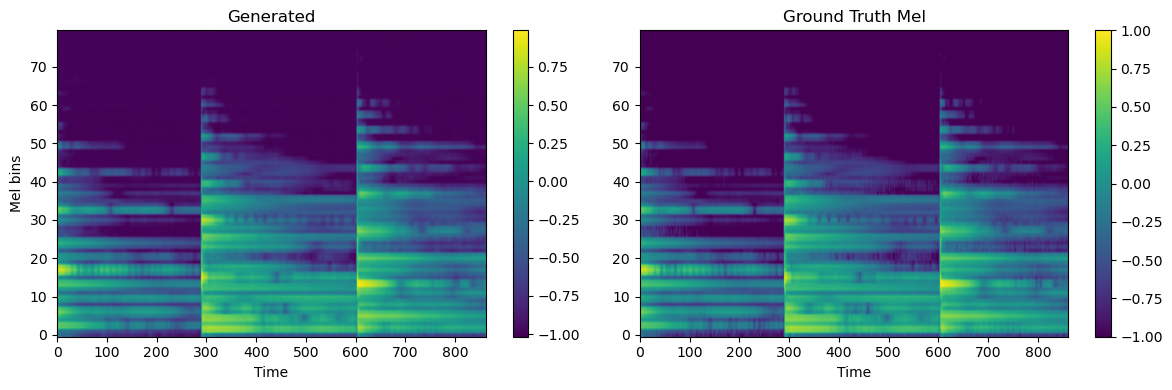

In [ ]:
import matplotlib.pyplot as plt

i, j = 0, 6  

root_dir = "mel_output"
gen_path   = os.path.join(root_dir, f"sample_{i}_{j}.npy")
gt_path    = os.path.join(root_dir, f"ground_truth_sample_{i}_{j}.npy")

mel_gen   = np.load(gen_path)      # (80, T)
mel_gt    = np.load(gt_path)      # (80, T)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(mel_gen, aspect='auto', origin='lower')
plt.title("Generated")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mel_gt, aspect='auto', origin='lower')
plt.title("Ground Truth Mel")
plt.xlabel("Time")
plt.colorbar()

plt.tight_layout()
plt.show()
